## Синтез нечеткого логического регулятора через решение задачи регрессии

**Общая постановка задачи**: используя известные значения сигналов замкнутой САУ, синтезировать нечеткую регрессионную модель и апробировать её в качестве ПД-регулятора данной системы.

In [1]:
import numpy as np
import pandas as pd

from IPython.display import HTML
from matplotlib import cm, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2

%matplotlib inline
%config InlineBackend.figure_format = 'png'

## Нечеткий ПД-регулятор

В роли регулятора САУ и эталонной модели выбран нечеткий ПД-регулятор (далее НЛР) - в том числе для прямого сравнения его настроек и работы с настройками и работой нечеткой регрессионной модели (далее НРМ), которая будет его оценкой.

Определим ключевые настройки эталонного НЛР:
 - функции принадлежности (ФП) нечетких входных переменных (рассогласование системы $e$ и его производная $d$) и нечеткой выходной переменной (управляющий сигнал $x$) - линейные, опреденные на [-1; 1], с термами {-1, 0, 1}.

In [2]:
def mf_left(k, gamma=1, t=(-1, 0)):
    if k < t[0]:
        return 1.
    elif k > t[1]:
        return 0.
    else:
        return abs( ((float(k) - t[1]) / (t[0] - t[1])) ** gamma )
    
def mf_centre(k, gamma_left=1, gamma_right=1, t=(-1, 0, 0, 1)):
    if k < t[0] or k > t[3]:
        return 0.
    elif t[0] <= k <= t[1]:
        return abs( ((float(k) - t[0]) / (t[1] - t[0])) ** gamma_left  )       
    elif t[2] <= k <= t[3]:
        return abs( ((float(k) - t[3]) / (t[2] - t[3])) ** gamma_right  )    
    else:
        return 1.
    
def mf_right(k, gamma=1, t=(0, 1)):
    if k > t[1]:
        return 1.
    elif k < t[0]:
        return 0.
    else:        
        return abs( ((float(k) - t[0]) / (t[1] - t[0])) ** gamma )

In [3]:
fuzzy_e = {'-1': lambda k: mf_left(k, t=(-1, 0)),
            '0': lambda k: mf_centre(k, t=(-1, 0, 0, 1)),
            '1': lambda k: mf_right(k, t=(0, 1))}

fuzzy_d = {'-1': lambda k: mf_left(k, t=(-1, 0)),
            '0': lambda k: mf_centre(k, t=(-1, 0, 0, 1)),
            '1': lambda k: mf_right(k, t=(0, 1))}

fuzzy_x = {'-1': lambda k: mf_left(k, t=(-1, 0)),
            '0': lambda k: mf_centre(k, t=(-1, 0, 0, 1)),
            '1': lambda k: mf_right(k, t=(0, 1))}

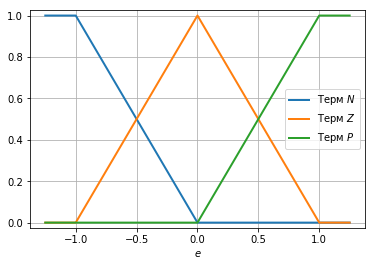

In [4]:
e_space = pd.Series(np.linspace(-1.25, 1.25, 101))

for term, label, in zip(['-1', '0', '1'],
                       [u'Терм $N$', u'Терм $Z$', u'Терм $P$', u'j']):
    plt.plot(e_space, e_space.apply(fuzzy_e[term]), linewidth=2, label=label)

plt.legend(loc='best')  
plt.xlabel('$e$')
# plt.ylabel('$m_E(e)$')
plt.ylim([-0.025, 1.025])
plt.grid(True)
plt.show()

 - реляционная матрица **$R_{MAM}$** - вещественное отображение базы нечетких продукционных правид, «решительный» вариант только из 0 и 1;

In [5]:
index = pd.MultiIndex.from_product([fuzzy_e.keys(), fuzzy_d.keys()],
                                    names=['e', 'd'])
R = pd.DataFrame([[1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1]], 
                 columns=fuzzy_x.keys(), index=index).rename_axis('x', axis=1)

R

x      1  0  -1
e  d           
1  1   1  0   0
   0   1  0   0
   -1  0  1   0
0  1   1  0   0
   0   0  1   0
   -1  0  0   1
-1 1   0  1   0
   0   0  0   1
   -1  0  0   1

 - степени значимости нечетких входных переменных $e$ и $d$ - по умолчанию полная значимость.

In [6]:
b = [1, 1]

Программная реализация нечеткого ПД-регулятора:

In [7]:
class FuzzyPDController:
    
    def __init__(self, fuzzy_e, fuzzy_d, fuzzy_x, R, b, def_type):
        self.fuzzy_e = fuzzy_e
        self.fuzzy_d = fuzzy_d
        self.fuzzy_x = fuzzy_x        
        self.R = R
        self.b_e, self.b_d = b
        self.def_type = def_type
        self.x_terms = self.fuzzy_x.keys()  
        self.x_space = pd.DataFrame(np.linspace(-1., 1., 101), columns=['x'])
        
    
    def predict(self, variables):
        e, d = variables        
        interference = self.R.reset_index()
        
        interference['e'] = interference['e'].apply(lambda r: min(self.fuzzy_e[r](e), self.b_e))
        interference['d'] = interference['d'].apply(lambda r: min(self.fuzzy_d[r](d), self.b_d))
        
        interference['_act'] = interference[['e', 'd']].min(axis=1)
        
        for term in self.x_terms:
            interference[term] = interference[[term, '_act']].min(axis=1)
            
        accumulation = interference[self.x_terms].max(axis=0)
        
        if np.max(accumulation) == 0:
            return 0
        
        for term in self.x_terms:
            self.x_space[term] = self.x_space['x'].apply( \
                                 lambda x: min(self.fuzzy_x[term](x),
                                               accumulation[term]))
    
        self.x_space['_dfz'] = self.x_space[self.x_terms].max(axis=1)
        
        if self.def_type == 'c':
            x = np.sum(self.x_space._dfz * self.x_space.x) / np.sum(self.x_space._dfz)
        elif self.def_type == 'lm':
            x = self.x_space.x[self.x_space._dfz == self.x_space._dfz.max()].iloc[0]
        elif self.def_type == 'rm':
            x = self.x_space.x[self.x_space._dfz == self.x_space._dfz.max()].iloc[-1]
        else:
            x = self.x_space.x[self.x_space._dfz == self.x_space._dfz.max()].mean()
        
        return x

Статические характеристики нечетких ПД-регуляторов $f(e, 0)$ с различными методами дефаззификации (центр тяжести, левое, правое и среднее модальное значения):

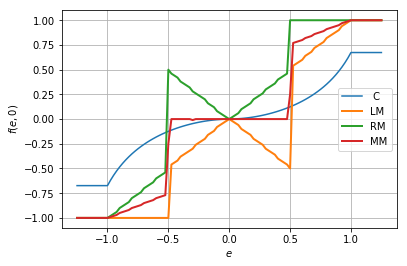

In [8]:
pdc = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, R, b, 'c')
pdc_lm = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, R, b, 'lm')
pdc_rm = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, R, b, 'rm')
pdc_mm = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, R, b, 'mm')

plt.plot(e_space, e_space.apply(lambda e: pdc.predict([e, 0.])), label=' C')
plt.plot(e_space, e_space.apply(lambda e: pdc_lm.predict([e, 0.])), linewidth=2, label='LM')
plt.plot(e_space, e_space.apply(lambda e: pdc_rm.predict([e, 0.])), linewidth=2, label='RM')
plt.plot(e_space, e_space.apply(lambda e: pdc_mm.predict([e, 0.])), linewidth=2, label='MM')
plt.legend(loc='right')  
plt.xlabel('$e$')
plt.ylabel('$f(e, 0)$')
plt.grid(True)
plt.show()

Метод центра тяжести явно предпочтительнее.

## Система автоматического управления

САУ с эталонным нечетким ПД-регулятором выступает в качестве источника данных для задачи регресии.

Она представляет собой замкнутый контур с отрицательной обратной связью, с нормально распреденным шумом с нулевым матожиданием и единичной дисперсией мощностью 0.01 на входе, а также с объектом управления в виде последовательно стоящих интегратора и единичного инерционного звена. Регулятор расположен перед объектом управления.

Передаточная функция тестового объекта:

$W(p)=\frac{k}{(1+T \cdot p)\cdot p}$

где $k=1$, $T=1$, $p$ - оператор Лапласа.

В САУ следующие сигналы:
 - $u(t)$ - уставка системы;
 - $e(t)$ - рассогласование системы (сумма нормированного $u(t)$, шума и $y(t)$ по отрицательной обратной связи);
 - $d(t)$ - приращение / производная рассогласования системы $e(t)$;
 - $x(t)$ - управляющий сигнал на объект;
 - $y(t)$ - выходной сигнал системы по нормированной шкале;
 - $o(t)$ - выходной сигнал системы по ненормированной шкале.

In [9]:
dt = 0.2
t = np.arange(0, 50 + dt, dt)

t.shape[0]

251

Программная реализация САУ:

In [10]:
def control_system(pdc, random_state, u0=0., u1=1., dt=0.2, e=None, o=None):
    if e is None:
        e = u0 
    if o is None:
        o = [u0, u0]
        
    k0, T0 = 1., 1.
    dt = dt    
    
    s = pd.DataFrame(columns=['u', 'n', 'e', 'd', 'x', 'y', 'o'],
                     index=[-2, -1]).fillna(0)
    s.e[-1] = (e - u0) / (u1 - u0)
    s.y[-2, -1] = (np.array(o) - u0) / (u1 - u0)
    
    np.random.seed(random_state)
    
    for k in range(0, 251):
        s.loc[k, 'u'] = u1
        s.loc[k, 'n'] = np.random.randn(1)[0] * 0.05
        s.loc[k, 'e'] = (s.loc[k, 'u'] - u0) / (u1 - u0) - s.loc[k-1, 'y'] + s.loc[k, 'n']
        s.loc[k, 'd'] = s.loc[k, 'e'] - s.loc[k-1, 'e']
        s.loc[k, 'x'] = pdc.predict(s[['e', 'd']].loc[k])
        s.loc[k, 'y'] = (1. / (T0 + dt)) * (k0 * dt * dt * s.loc[k, 'x'] + \
                        (2. * T0 + dt) * s.loc[k-1, 'y'] - T0 * s.loc[k-2, 'y'])
        
    s.drop([-2, -1], inplace=True)

    s['o'] = s.y * (u1 - u0) + u0    
        
    return s

Сигналы САУ с эталонным нечетким ПД-регулятором:

In [11]:
s = control_system(pdc, random_state=1989, dt=dt)

Сигналы $u(t)$ и $y(t)$ САУ с эталонным нечетким ПД-регулятором - уставка изменяется от 0 до 1:

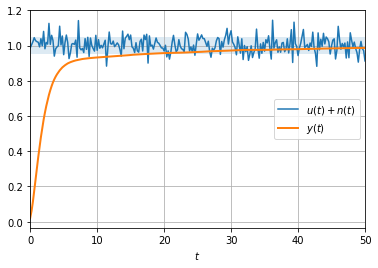

In [12]:
plt.fill_between(t, 0.95 * s.u, 1.05 * s.u, alpha=0.15)
plt.plot(t, s.u + s.n, label='$u(t)+n(t)$')
plt.plot(t, s.y, lw=2, label='$y(t)$')

plt.legend(loc='right')
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

Сигналы $e(t)$, $d(t)$ и $x(t)$ САУ с эталонным нечетким ПД-регулятором:

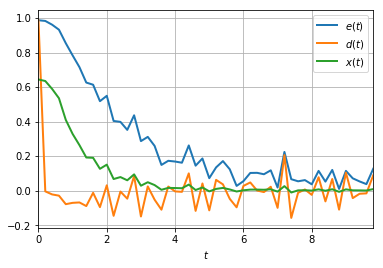

In [13]:
plt.plot(t[:50], s.e[:50], label='$e(t)$',lw=2)
plt.plot(t[:50], s.d[:50], label='$d(t)$',lw=2)
plt.plot(t[:50], s.x[:50], label='$x(t)$',lw=2)

plt.legend(loc='upper right')  
plt.xlim([t[0], t[50-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

Для обучения НРМ будет достаточно первых 50-ти, наиболее информативных значений - далее эти сигналы устанавливаются.

## Анализ данных и подготовка выборки

Представим каждый временной отсчет на графиках выше как объект, а значения сигналов на нем как его признаки. Пусть значения $e(t)$ и $d(t)$ составляют матрицу "объекты-признаки" ***X***, а соответствующие им значения $x(t)$ – целевой вектор ***y***.

Отметим, что здесь их совокупность не является традиционным временным рядом, поэтому порядок значений не важен. Кроме того, поскольку задача носит скорее идентификационный характер, критичный для задач регрессии факт корреляции $e(t)$ и $d(t)$ можно не учитывать, а обучение производить на всех данных, без выделения из них тестовой выборки. Проверкой качества работы НРМ будут переходные процессы САУ, включающей ее как регулятор.

Ниже приведены ФП термов {$N$, $Z$, $P$} для двух входных и одной выходной переменных НРМ, построенные предлагавшимся способом – на основе гистограмм значений сигналов $e(t)$, $d(t)$, $x(t)$.

In [14]:
fuzzy_e2 = {'-1': lambda k: mf_left(k, t=(-1, 0)), # можно убрать
             '0': lambda k: mf_centre(k, t=(-1, 0, 0, 1)),
             '1': lambda k: mf_right(k, t=(0.3, 1))}

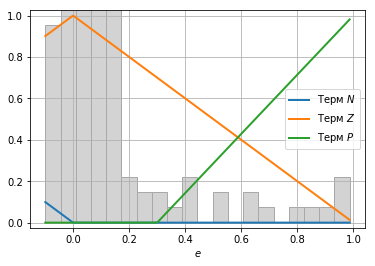

In [15]:
s.e.hist(bins=20, color='lightgrey', density=True, ec='darkgrey')

e_space2 = pd.Series(np.linspace(s.e.min(), s.e.max(), 201))

for term, label, in zip(['-1', '0', '1'],
                       [u'Терм $N$', u'Терм $Z$', u'Терм $P$', u'j']):
    plt.plot(e_space2, e_space2.apply(fuzzy_e2[term]), linewidth=2, label=label)

plt.legend(loc='best')  
plt.xlabel('$e$')
# plt.ylabel('$m_E(e)$')
plt.ylim([-0.025, 1.025])
plt.grid(True)
plt.show()

In [16]:
fuzzy_d2 = {'-1': lambda k: mf_left(k, t=(-1, 0)), # можно убрать
             '0': lambda k: mf_centre(k, t=(-0.3, 0., 0, 0.3)),
             '1': lambda k: mf_right(k, t=(0, 1))}

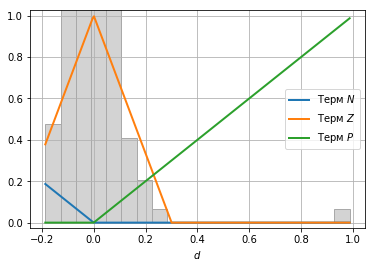

In [17]:
s.d.hist(bins=20, color='lightgrey', density=True, ec='darkgrey')

d_space2 = pd.Series(np.linspace(s.d.min(), s.d.max(), 201))

for term, label in zip(['-1', '0', '1'],
                       [u'Терм $N$', u'Терм $Z$', u'Терм $P$', u'j']):
    plt.plot(d_space2, d_space2.apply(fuzzy_d2[term]), linewidth=2, label=label)
    
plt.legend(loc='best')  
plt.xlabel('$d$')
# plt.ylabel('$m_D(d)$')
plt.ylim([-0.025, 1.025])
plt.grid(True)
plt.show()

In [18]:
fuzzy_x2 = {'-1': lambda k: mf_left(k, t=(-0.33, 0)), # можно убрать
             '0': lambda k: mf_centre(k, t=(-0.33, 0, 0, 0.33)),
             '1': lambda k: mf_right(k, t=(0, 0.7))} # t=(0, 0.2)

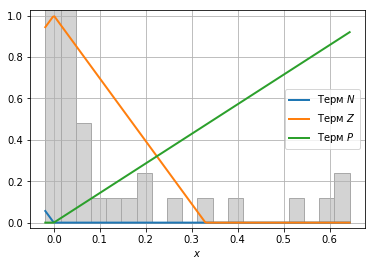

In [19]:
s.x.hist(bins=20, color='lightgrey', density=True, ec='darkgrey')

x_space2 = pd.Series(np.linspace(s.x.min(), s.x.max(), 201))

for term, label in zip(['-1', '0', '1'],
                       [u'Терм $N$', u'Терм $Z$', u'Терм $P$', u'j']):
    plt.plot(x_space2, x_space2.apply(fuzzy_x2[term]), linewidth=2, label=label)

plt.legend(loc='best')  
plt.xlabel('$x$')
# plt.ylabel('$m_X(x)$')
plt.ylim([-0.025, 1.025])
plt.grid(True)
plt.show()

Матрица "объекты-признаки" ***X***

In [20]:
X = s[['e', 'd']].loc[:50]

X.head()

,e,d
0,0.986814,0.986814
1,0.982805,-0.004009
2,0.960991,-0.021813
3,0.932067,-0.028925
4,0.853842,-0.078225


Целевой вектор ***y***

In [21]:
y = s.x[:50]
y.rename('x', inplace=True)

y.head()

0    0.643834
1    0.634903
2    0.589147
3    0.535132
4    0.409974
Name: x, dtype: float64

## Обучение модели


In [22]:
class GreyRevival:
    
    def __init__(self, ifvs, ofv, weighted=True, target_lims=[-1, 1]):
        self.ifvs = ifvs
        self.ofv = ofv
        self.rules_info = None
        self.weighted = weighted    
        self.feature_names = None
        self.target_name = None
        self.r_matrix = None
        self.target_terms = ofv.keys()
        self.target_space = pd.DataFrame(np.linspace(target_lims[0], target_lims[1], 101),
                                         columns=['_trgt'])
        self.target_default = np.mean(target_lims)
        
        
    def make_fuzzy(self, info_line):    
        index = info_line[info_line != 0].index
        conclusion = pd.Series(index=index).fillna(0)
    
        for f in range(4): # 4: counts, max, median, mean
            stat = info_line[index].apply(lambda x: x[f])
            index = stat[stat == stat.max()].index
            if len(index) == 1:
                break
    
        conclusion[index[0]] = 1
    
        return conclusion
    
    
    def make_proba(self, info_line):    
        counts = info_line[info_line != 0].apply(lambda x: x[0])        
        probabilities = counts / np.sum(counts)
        return probabilities
        
    
    def fuzzyficate(self, all_data):
        all_features = self.feature_names + [self.target_name]
        df = pd.DataFrame(columns=all_features)
        cs = [feature + '_c' for feature in all_features]        
        
        for feature, fv in zip(all_features, self.ifvs + [self.ofv]):
            feature_terms = list(fv.keys())
            for term in feature_terms:
                df[term] = all_data[feature].apply(fv[term])
        
            df[feature + '_c'] = df[feature_terms].max(axis=1)
            df[feature] = df[feature_terms].idxmax(axis=1)
        
            df = df.drop(feature_terms, axis=1)
            
        df['c'] = df[cs].min(axis=1)
        df = df.drop(cs, axis=1)        
        
        return df
  
    
    def fit(self, X, y):
        self.feature_names = list(X.columns)
        self.target_name = y.name
            
        all_data = pd.concat([X, y], axis=1)
        df = self.fuzzyficate(all_data)
    
        self.rules_info = pd.pivot_table(df, values='c', index=self.feature_names, 
                                         columns=self.target_name, fill_value=0,
                                         aggfunc={'c': lambda s: [len(s), np.max(s),
                                                                  np.median(s), np.mean(s)]})    
        
        make_rm = self.make_fuzzy if self.weighted else self.make_proba
        rules_base = self.rules_info.apply(make_rm, axis=1).fillna(0)
        
        index = pd.MultiIndex.from_product(self.ifvs, names=self.feature_names)
        self.r_matrix = pd.DataFrame(columns=self.ofv.keys(), index=index).fillna(0.)     
        self.r_matrix.rename_axis(self.target_name, axis=1, inplace=True)
        self.r_matrix.loc[rules_base.index, rules_base.columns] = rules_base
        
        ## неполная, без нулевых строк
        # self.r_matrix = pd.DataFrame(columns=self.ofv.keys())
        # self.r_matrix[rules_base.columns] = rules_base
        # self.r_matrix = self.r_matrix.rename_axis(self.target_name, axis=1).fillna(0.)
                
        return HTML("GreyRevival(features={}, target='{}')".format(self.feature_names,
                                                                   self.target_name))
        
        
    def interfere(self, variables):
        interference = self.r_matrix.reset_index()
        for feature, fv, var in zip(self.feature_names, self.ifvs, variables):
            interference[feature] = interference[feature].apply(lambda term: fv[term](var))
        
        interference['_act'] = interference[self.feature_names].min(axis=1)
        
        for term in self.target_terms:
            interference[term] = interference[[term, '_act']].min(axis=1)
            
        accumulation = interference[self.target_terms].max(axis=0)
        
        if np.max(accumulation) == 0:
            return self.target_default

        for term in self.target_terms:
            self.target_space[term] = self.target_space['_trgt'].apply( \
                                      lambda x: min(self.ofv[term](x),
                                                    accumulation[term]))
        
        self.target_space['_dfz'] = self.target_space[self.target_terms].max(axis=1)
        
        crisp_value = np.sum(self.target_space._dfz * self.target_space._trgt) / \
                      np.sum(self.target_space._dfz)

        return crisp_value
        
        
    def predict(self, X):
        if np.array(X).size == len(self.feature_names):
            return self.interfere(X)
        return X.apply(self.interfere, axis=1)

In [23]:
ifvs = [fuzzy_e2, fuzzy_d2]
ofv = fuzzy_x2

In [24]:
grey_revival = GreyRevival(ifvs, ofv)

grey_revival.fit(X, y)

In [25]:
# при weighted=False по x немного хуже, по y лучше
grey_revival_proba = GreyRevival(ifvs, ofv, weighted=False)

grey_revival_proba.fit(X, y)

"Нечеткая" реляционная матрица $R_{FULL}$

In [26]:
r = grey_revival.r_matrix

r

x        1    0   -1
e  d                
1  1   1.0  0.0  0.0
   0   1.0  0.0  0.0
   -1  0.0  0.0  0.0
0  1   0.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0
-1 1   0.0  0.0  0.0
   0   0.0  0.0  0.0
   -1  0.0  0.0  0.0

"Вероятностная" реляционная матрица $R_{PRB}$

In [27]:
r_proba = grey_revival_proba.r_matrix

r_proba

x         1     0   -1
e  d                  
1  1   1.00  0.00  0.0
   0   0.75  0.25  0.0
   -1  0.00  0.00  0.0
0  1   0.00  0.00  0.0
   0   0.00  1.00  0.0
   -1  0.00  0.00  0.0
-1 1   0.00  0.00  0.0
   0   0.00  0.00  0.0
   -1  0.00  0.00  0.0

## Проверка работы модели


In [28]:
pdc_r = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, r, b, 'c')

pdc2 = FuzzyPDController(fuzzy_e2, fuzzy_d2, fuzzy_x2, r, b, 'c')
pdc2_proba = FuzzyPDController(fuzzy_e2, fuzzy_d2, fuzzy_x2, r_proba, b, 'c')

**Статические характеристики**

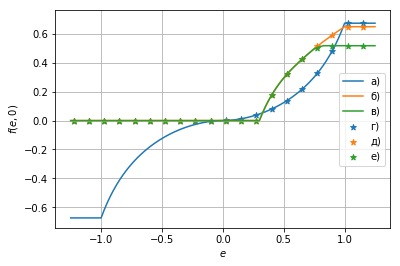

In [29]:
#df_e = pd.DataFrame({'e': e_space}, columns=['e', 'd']).fillna(0.)

plt.plot(e_space, e_space.apply(lambda e: pdc.predict([e, 0.])), label=u'а)')
plt.scatter(e_space[1::5], e_space[1::5].apply(lambda e: pdc_r.predict([e, 0.])), label=u'г)', marker='*')
plt.plot(e_space, e_space.apply(lambda e: pdc2.predict([e, 0.])), label=u'б)')
plt.scatter(e_space[1::5], e_space[1::5].apply(lambda e: grey_revival.predict([e, 0.])), label=u'д)', marker='*')
plt.plot(e_space, e_space.apply(lambda e: pdc2_proba.predict([e, 0.])), label=u'в)')
plt.scatter(e_space[1::5], e_space[1::5].apply(lambda e: grey_revival_proba.predict([e, 0.])), label=u'е)', marker='*')
plt.legend(loc='right')  
plt.xlabel('$e$')
plt.ylabel('$f(e, 0)$')
plt.grid(True)
plt.show()

* а)	НЛР с исходными линейными ФП НЛР и исходной реляционной матрицей $R_{MAM}$
* б) 	НЛР с оцененными ФП НРМ и нечеткой $R_{FULL}$
* в)	НЛР с оцененными ФП НРМ и вероятностной $R_{PRB}$
* г)	НЛР с исходными линейными ФП НЛР и нечеткой $R_{FULL}$
* д)	НРМ с оцененными ФП НРМ и нечеткой $R_{FULL}$
* е)	НРМ с оцененными ФП НРМ и вероятностной $R_{PRB}$

In [30]:
s2_pd = control_system(pdc2, random_state=42, dt=dt)
prediction2 = grey_revival.predict(s2_pd[['e', 'd']])

np.testing.assert_array_equal(prediction2, s2_pd.x)

In [31]:
s2 = control_system(grey_revival, random_state=42, dt=dt)
s2_proba = control_system(grey_revival_proba, random_state=42, dt=dt)

**Сигналы САУ**

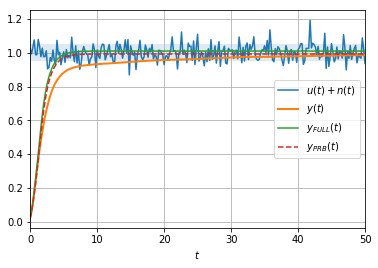

In [32]:
plt.fill_between(t, 0.95 * s.u, 1.05 * s.u, alpha=0.15)
plt.plot(t, s.u + s2.n, label='$u(t)+n(t)$')
plt.plot(t, s.y, label='$y(t)$',lw=2)
plt.plot(t, s2.y, label='$y_{FULL}(t)$')
plt.plot(t, s2_proba.y, label='$y_{PRB}(t)$', linestyle='--')

plt.legend(loc='right')
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

*	$y(t)$ от НЛР с исходными линейными ФП НЛР и исходной реляционной матрицей $R_{MAM}$ 
*	$y_{FULL}(t)$ от НРМ с оцененными ФП НРМ и нечеткой $R_{FULL}$
*	$y_{PRB}(t)$ от НРМ с оцененными ФП НРМ и вероятностной $R_{PRB}$

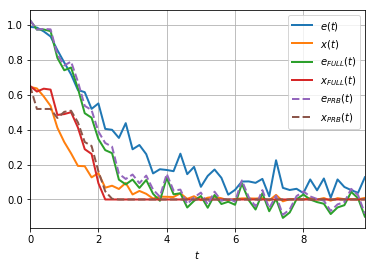

In [33]:
plt.plot(t[:50], s.e[:50], label='$e(t)$',lw=2)
plt.plot(t[:50], s.x[:50], label='$x(t)$',lw=2)
plt.plot(t[:50], s2.e[:50], label='$e_{FULL}(t)$',lw=2)
plt.plot(t[:50], s2.x[:50], label='$x_{FULL}(t)$',lw=2)
plt.plot(t[:50], s2_proba.e[:50], label='$e_{PRB}(t)$',lw=2, linestyle='--')
plt.plot(t[:50], s2_proba.x[:50], label='$x_{PRB}(t)$',lw=2, linestyle='--')

plt.legend(loc='upper right')
plt.xlim([t[0], t[50-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

* $e(t)$, $x(t)$ от НЛР с исходными линейными ФП НЛР и исходной реляционной матрицей $R_{MAM}$
* $e_{FULL}(t)$, $x_{FULL}(t)$ от НРМ с оцененными ФП НРМ и нечеткой $R_{FULL}$
* $e_{PRB}(t)$, $x_{PRB}(t)$ от НРМ с оцененными ФП НРМ и вероятностной $R_{PRB}$

**Отклонения процессов друг от друга**

In [34]:
print mse(s.x, s2.x), mse(s.x, s2_proba.x)
print mse(s.y, s2.y), mse(s.y, s2_proba.y)

0.0008496510799482556 0.001025421593764166
0.0034926254500162956 0.00182817366102456


In [35]:
print mae(s.x, s2.x), mae(s.x, s2_proba.x)
print mae(s.y, s2.y), mae(s.y, s2_proba.y)

0.009982708337623306 0.010274338019915622
0.05198488913511808 0.03398491188347235


Коэффициент детерминации

In [36]:
print r2(s.x, s2.x), r2(s.x, s2_proba.x)
print r2(s.y, s2.y), r2(s.y, s2_proba.y)

0.8846353396194153 0.8607694185256314
0.8398489217356696 0.916170804096338


Примеры успешной работы САУ в условиях меняющегося значения уставки – с нечеткой моделью ПД-регулятора на основе одной из оцененных матриц $R_{FULL}$

In [37]:
u0 = -1.08 # -3.
u1 = -3.27 # -5.

s3 = control_system(grey_revival, u0=u0, u1=u1, random_state=2019, dt=dt)

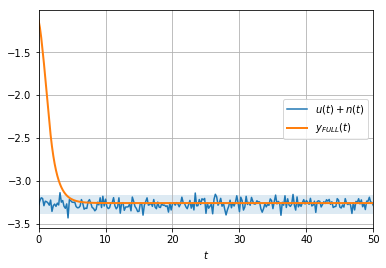

In [38]:
plt.fill_between(t, 0.95 * (s3.u - u0) + u0, 1.05 * (s3.u - u0) + u0, alpha=0.15)
plt.plot(t, s3.u + s3.n, label='$u(t)+n(t)$')
plt.plot(t, s3.o, label='$y_{FULL}(t)$',lw=2)

plt.legend(loc='right')
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

In [39]:
u_levels = [3., -1., 2., -1.5, 2.5, 3.]

df_long = pd.DataFrame(columns=['u', 'n', 'o'])
e_k, o_k = None, None
for u0, u1, n in zip(u_levels[:-1], u_levels[1:], [5, 2, 3, 7, 9]):
    s_k = control_system(grey_revival, u0=u0, u1=u1, random_state=n, dt=dt, e=e_k, o=o_k)
    e_k = s_k.e.iloc[-1] * (u1 - u0) + u0
    o_k = s_k.o.iloc[-2:]
    df_long = pd.concat([df_long, s_k[['u', 'n', 'o']]], ignore_index=True)

t_long = df_long.index * dt

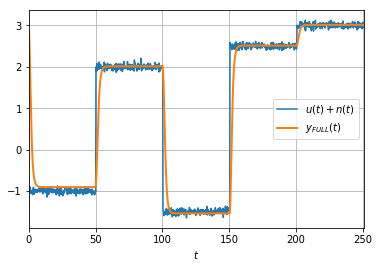

In [40]:
plt.plot(t_long, df_long.u + df_long.n, label='$u(t)+n(t)$')
plt.plot(t_long, df_long.o, label='$y_{FULL}(t)$',lw=2)

plt.legend(loc='right')
plt.xlim([t_long[0], t_long[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

## Регуляризация

Регуляризация признака – это его штрафное ограничение или сокращение влияния на результат модели, как правило, во избежание ее переобучения. Влияние признака может уменьшаться вплоть до его полного исключения из модели.

В нечетких моделях схожую роль играют степень значимости подусловия нечеткого правила $\beta$ из отрезка $[0,1]$, по сути, являющаяся его весовым коэффициентом. Степени значимости используются в уже обученной нечеткой модели.

Пусть для входной переменной $e$ введен пороговый терм, соответствующий значениям признака, на которых результаты всех (или определенных) ФП не меньше заданного числа $\beta_{e}$.

Покажем этот подход в САУ с нечетким ПД-регулятором, где требуется понизить влияние сигнала $e(t)$. Модифицируем его построенные на основе гистограммы значений треугольные ФП, задав порог $\beta_{e}=0.65$, для остальных сигналов все оставим без изменений, как в примерах выше.

In [41]:
pdc_b = FuzzyPDController(fuzzy_e, fuzzy_d, fuzzy_x, R, [0.15, 1], 'c')

In [42]:
b_e = 0.65
fuzzy_e3 = {'-1': fuzzy_e2['-1'], # можно убрать
             '0': lambda k: fuzzy_e2['0'](k) if fuzzy_e2['0'](k) <= b_e else 0.,
             '1': lambda k: fuzzy_e2['1'](k) if fuzzy_e2['1'](k) <= b_e else 0.,
             '~': lambda k: 1. if (fuzzy_e2['0'](k) > b_e) or (fuzzy_e2['1'](k) > b_e) else 0.}

# fuzzy_e4 = {'~': lambda k: 1.}

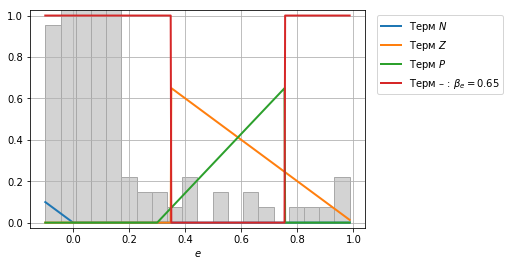

In [43]:
s.e.hist(bins=20, color='lightgrey', density=True, ec='darkgrey')

e_space3 = pd.Series(np.linspace(s.e.min(), s.e.max(), 501))

for term, label in zip(['-1', '0', '1', '~'],
                       [u'Терм $N$', u'Терм $Z$', u'Терм $P$', u'Терм $–$ : $β_e=0.65$']):
    plt.plot(e_space3, e_space3.apply(fuzzy_e3[term]), linewidth=2, label=label)

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.xlabel('$e$')
# plt.ylabel('$m_E(e)$')
plt.ylim([-0.025, 1.025])
plt.grid(True)
plt.show()

Видно: что чем меньше пороговое значение $\beta$, тем шире ступенчатая ФП терма-регуляризатора, и тем меньше значений признака, которые способны обеспечить в базе нечеткой модели прежние правила.

In [44]:
grey_revival_b = GreyRevival([fuzzy_e3, fuzzy_d2], fuzzy_x2)

grey_revival_b.fit(X, y)

In [45]:
grey_revival_b.r_matrix

x        1    0   -1
e  d                
1  1   0.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0
0  1   0.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0
-1 1   0.0  0.0  0.0
   0   0.0  0.0  0.0
   -1  0.0  0.0  0.0
~  1   1.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0

In [46]:
s4 = control_system(pdc_b, random_state=42, dt=dt)
s5 = control_system(grey_revival_b, random_state=42, dt=dt)

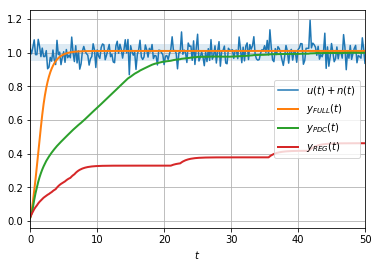

In [47]:
plt.fill_between(t, 0.95 * s.u, 1.05 * s.u, alpha=0.15)
plt.plot(t, s.u + s4.n, label='$u(t)+n(t)$')
plt.plot(t, s2.o, label='$y_{FULL}(t)$',lw=2)
plt.plot(t, s4.o, label='$y_{PDC}(t)$',lw=2)
plt.plot(t, s5.o, label='$y_{REG}(t)$',lw=2)

plt.legend(loc='right')
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

По виду процессов $y(t)$ и $y_{REG}(t)$ можно сказать, что с помощью предложенного варианта регуляризации сигнала $e(t)$ удалось добиться вполне закономерного эффекта уменьшения коэффициента усиления в САУ.

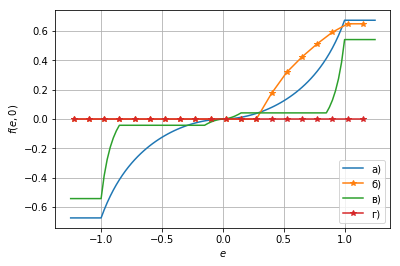

In [48]:
plt.plot(e_space, e_space.apply(lambda e: pdc.predict([e, 0.])), label=u'а)')
plt.plot(e_space[1::5], e_space[1::5].apply(lambda e: grey_revival.predict([e, 0.])), label=u'б)', marker='*')
plt.plot(e_space, e_space.apply(lambda e: pdc_b.predict([e, 0.])), label=u'в)')
plt.plot(e_space[1::5], e_space[1::5].apply(lambda e: grey_revival_b.predict([e, 0.])), label=u'г)', marker='*')
plt.legend(loc='lower right')  
plt.xlabel('$e$')
plt.ylabel('$f(e, 0)$')
plt.grid(True)
plt.show()

## Регуляризация *немного подробнее


In [49]:
def regularized_e(b_e):
    return {'-1': fuzzy_e2['-1'], # можно убрать
             '0': lambda k: fuzzy_e2['0'](k) if fuzzy_e2['0'](k) <= b_e else 0.,
             '1': lambda k: fuzzy_e2['1'](k) if fuzzy_e2['1'](k) <= b_e else 0.,
             '~': lambda k: 1. if (fuzzy_e2['0'](k) > b_e) or (fuzzy_e2['1'](k) > b_e) else 0.}

In [50]:
fuzzy_e3 = regularized_e(0.75)
fuzzy_e4 = regularized_e(0.85)

fuzzy_e5 = {'~': lambda k: 1.}

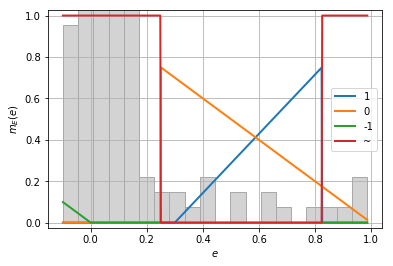

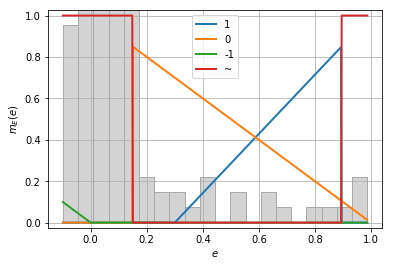

In [51]:
e_space3 = pd.Series(np.linspace(s.e.min(), s.e.max(), 501))

for fv in (fuzzy_e3, fuzzy_e4):

    s.e.hist(bins=20, color='lightgrey', density=True, ec='darkgrey')
    
    for term, mf in fv.items():
        plt.plot(e_space3, e_space3.apply(mf), linewidth=2, label=term)
        
    plt.legend(loc='best')  
    plt.xlabel('$e$')
    plt.ylabel('$m_E(e)$')
    plt.ylim([-0.025, 1.025])
    plt.grid(True)
    plt.show()

In [52]:
grey_revival_b1 = GreyRevival([fuzzy_e3, fuzzy_d2], fuzzy_x2)
grey_revival_b1.fit(X, y)

grey_revival_b1.r_matrix

x        1    0   -1
e  d                
1  1   0.0  0.0  0.0
   0   1.0  0.0  0.0
   -1  0.0  0.0  0.0
0  1   0.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0
-1 1   0.0  0.0  0.0
   0   0.0  0.0  0.0
   -1  0.0  0.0  0.0
~  1   1.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0

In [53]:
grey_revival_b2 = GreyRevival([fuzzy_e4, fuzzy_d2], fuzzy_x2)
grey_revival_b2.fit(X, y)

grey_revival_b2.r_matrix

x        1    0   -1
e  d                
1  1   0.0  0.0  0.0
   0   1.0  0.0  0.0
   -1  0.0  0.0  0.0
0  1   0.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0
-1 1   0.0  0.0  0.0
   0   0.0  0.0  0.0
   -1  0.0  0.0  0.0
~  1   1.0  0.0  0.0
   0   0.0  1.0  0.0
   -1  0.0  0.0  0.0

In [54]:
grey_revival_b3 = GreyRevival([fuzzy_e5, fuzzy_d2], fuzzy_x2)
grey_revival_b3.fit(X, y)

grey_revival_b3.r_matrix

x       1    0   -1
e d                
~ 1   1.0  0.0  0.0
  0   0.0  1.0  0.0
  -1  0.0  0.0  0.0

Они разные.

In [55]:
# s4 = control_system(pdc_b, random_state=42, dt=dt)
# s5 = control_system(grey_revival_b1, random_state=42, dt=dt)
s6 = control_system(grey_revival_b2, random_state=42, dt=dt)
s7 = control_system(grey_revival_b3, random_state=42, dt=dt)

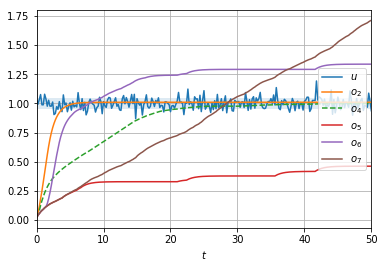

In [56]:
plt.fill_between(t, 0.95 * s.u, 1.05 * s.u, alpha=0.15)
plt.plot(t, s.u + s4.n, label='$u$')
plt.plot(t, s2.o, label='$o_2$')
plt.plot(t, s4.o, label='$o_4$', linestyle='dashed')
plt.plot(t, s5.o, label='$o_5$')
plt.plot(t, s6.o, label='$o_6$')
plt.plot(t, s7.o, label='$o_7$')

plt.legend(loc='right')
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.grid(True)
plt.show()

Статические характеристики:
* а)	НЛР с исходными линейными ФПНЛР и исходной реляционной матрицей RНЛР
* б) 	НРМ с оцененными ФПНРМ и взвешенной RНРМ 
* в)	НЛР с ФПНЛР , RНЛР и  be = 0.75
* г)	НРМ с R1РЕГ
* д)	НРМ с R2РЕГ 
* е)	НРМ с R3РЕГ

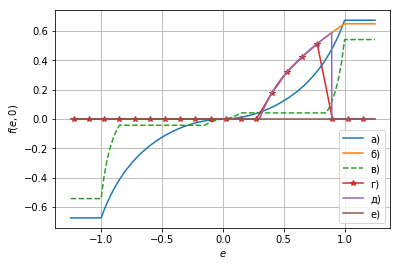

In [57]:
e_space4 = pd.Series(np.linspace(0, 1.25, 801))

plt.plot(e_space, e_space.apply(lambda e: pdc.predict([e, 0.])), label=u'а)')
plt.plot(e_space, e_space.apply(lambda e: grey_revival.predict([e, 0.])), label=u'б)')
plt.plot(e_space, e_space.apply(lambda e: pdc_b.predict([e, 0.])), linestyle='dashed', label=u'в)')
plt.plot(e_space[1::5], e_space[1::5].apply(lambda e: grey_revival_b1.predict([e, 0.])), label=u'г)', marker='*')
plt.plot(e_space4, e_space4.apply(lambda e: grey_revival_b2.predict([e, 0.])), label=u'д)')
plt.plot(e_space, e_space.apply(lambda e: grey_revival_b3.predict([e, 0.])), label=u'е)')
plt.legend(loc='lower right')  
plt.xlabel('$e$')
plt.ylabel('$f(e, 0)$')
plt.grid(True)
plt.show()

Поверхности для НРМ:

In [58]:
density = 25 
grid = np.meshgrid(np.linspace(-1., 1., density),
                   np.linspace(-1., 1., density))

E_grid, D_grid = grid
X_coords = pd.DataFrame(np.array(grid).T.reshape(-1, 2), columns=['e','d'])

In [59]:
def make_grid(grey_revival, X_coords, density=25):
    X_points = grey_revival.predict(X_coords).values
    X_grid = X_points.reshape(density, density)
    return X_grid

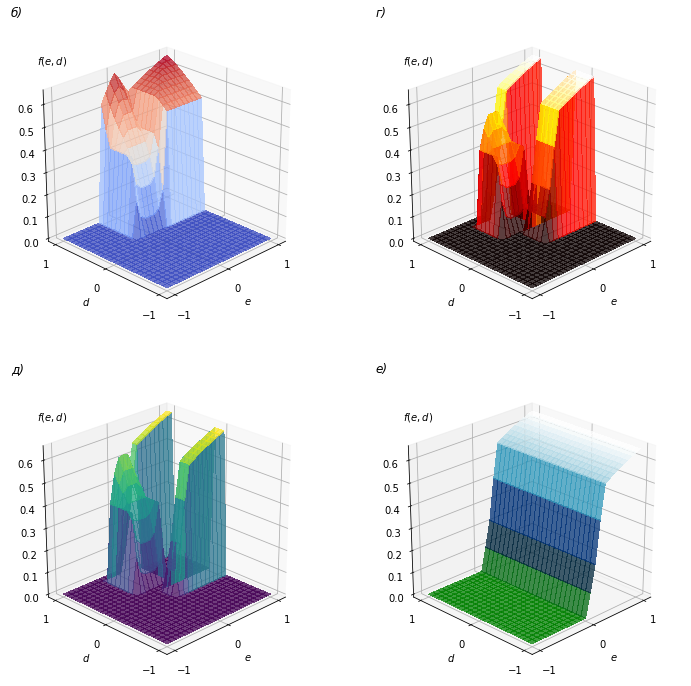

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'})
fig.set_size_inches(12, 12)

for ax, title, model, cmap in zip(axes.flatten(),
                                  [u'б)', u'г)', u'д)', u'е)'],
                                  [grey_revival, grey_revival_b1, \
                                   grey_revival_b2, grey_revival_b3],
                                  ['coolwarm', 'hot', 'viridis', 'ocean']):
    X_grid = make_grid(model, X_coords)
    ax.plot_surface(E_grid, D_grid, X_grid, linewidth=0, antialiased=False, alpha=0.75, cmap=cmap)
    ax.set_xlabel('$e$')
    ax.set_ylabel('$d$')
    ax.text(-1.35, 1, 0.8, '$f(e, d)$')
    ax.set_title(title, loc='left', fontstyle ='italic')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.view_init(25, -135)